In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "xxx" 
os.environ['KAGGLE_KEY'] = "xxx"
!kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 235M/242M [00:10<00:00, 20.7MB/s]
100% 242M/242M [00:10<00:00, 25.2MB/s]


In [ ]:
from zipfile import ZipFile
import string
zip = ZipFile('/content/drive/MyDrive/kaggle/amazon-fine-food-reviews.zip')
zip.extractall('/content/drive/MyDrive/kaggle/')

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/kaggle/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df_text = df.sample(n = 3000)

In [8]:
df_text.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
310125,310126,B008EM51FA,A39U8Z3OTYPHFC,Linda Singleton,0,0,5,1305504000,SOOTHING PLEASURE!!,THERE SHOULD BE 10 STARS FOR THIS PRODUCT! I ...
419897,419898,B005G2FC32,A310B8OFSNA5K5,Dudley Lamburt,0,0,5,1347580800,"Good Product, good price",My kids love these. They like that there is a ...
314609,314610,B000V1JVC6,A36FEPUTDN12KA,"a cute bear ""TNM""",6,8,4,1268697600,delicious but high in sodium,i have ordered it 5 times and will order it ag...
402531,402532,B000EML7DS,A1ZKBBOK1MOSOA,Linda R. Stanley,3,3,4,1260835200,a nice snack for low-carb,This makes a good snack for us low-carb folks....
87285,87286,B001EO616S,A1EWOJUUL7XRIX,Constant Reader,2,7,2,1312243200,Would not buy again,I thought the honey was much thinner than any ...


###Text Preprocessing

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:

import nltk
import re
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = doc.strip()
    
    tokens = nltk.word_tokenize(doc)
    
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df_text['Summary']))
len(norm_corpus)

3000

### Extract TF-IDF Features

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stop_words
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(3000, 157)

###Cluster Food Review using K-Means

In [15]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=6, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [16]:
from collections import Counter

Counter(km.labels_)

Counter({0: 192, 1: 341, 2: 2003, 3: 242, 4: 134, 5: 88})

In [17]:
df_text['kmeans_cluster'] = km.labels_

In [18]:
Food_Review_clusters = (df_text[['Summary', 'kmeans_cluster', 'Score']]
                  .sort_values(by=['kmeans_cluster', 'Score'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
Food_Review_clusters = Food_Review_clusters.copy(deep=True)

In [19]:
feature_names = cv.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    food_review = Food_Review_clusters[Food_Review_clusters['kmeans_cluster'] == cluster_num]['Summary'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Review Summary:', food_review)
    print('-'*80)

CLUSTER #1
Key Features: ['best', 'ever', 'tea', 'coffee', 'ive', 'one', 'far', 'simply', 'dog', 'found', 'chocolate', 'flavor', 'tasting', 'chips', 'green']
Popular Review Summary: ['Best dog treat - great for training', 'Best Dog Treat For Picky Dogs', 'best off-the-shelf salsa ever', 'The Best Bar on the Market Hands Down', 'The Best Hazelnut K-Cup!', 'Salsa Fresca is the best', 'Best ever', 'Salt & Pepper Popchips are the BEST!!!', 'Best deal on AMZ for bottle pumps', 'best chocolate ever', 'Best Hot Chocolate Flavor', 'Best Blue Diamond Almonds', 'This is Really Chocolate of the Best Type', 'The best flaver', 'The Best Funnel cake mix out there', 'One of the best hot chocolate mixes out there!', 'Best tasting pretzel snack', 'Best Cat Food', 'best syrup ever', 'THE BEST & MY FAV']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['great', 'product', 'great product', 'coffee', 'taste', 'price', 'tea', 'great coffee', 'great t

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_features = cosine_similarity(cv_matrix)
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)

Counter({0: 358, 1: 233, 2: 2003, 3: 86, 4: 191, 5: 129})

In [25]:
df_text['kmeans_cluster'] = km.labels_

Food_Review_clusters = (df_text[['Summary', 'kmeans_cluster', 'Score']]
                  .sort_values(by=['kmeans_cluster', 'Score'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
Food_Review_clusters = Food_Review_clusters.copy(deep=True)


for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    food_review = Food_Review_clusters[Food_Review_clusters['kmeans_cluster'] == cluster_num]['Summary'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Food Review:', food_review)
    print('-'*80)

CLUSTER #1
Key Features: ['best', 'ever', 'tea', 'coffee', 'ive', 'one', 'far', 'simply', 'dog', 'found', 'chocolate', 'flavor', 'tasting', 'chips', 'green']
Popular Food Review: ['Best dog treat - great for training', 'Great product', 'Works great, stopped her midnight screaming', 'Great', 'Great treat', 'Great Tea!', 'Tastes Great!', 'What a great solution! Better dog food for a great price!', 'Great fondant!', 'Great TASTY source of soluble fiber', 'Always great', 'great plant larger than expected', 'Great Coffee', 'Great stuff', 'Great Product', 'Great tasting coffee', 'Great product!', 'Great Treat', 'Great Nutritional Drink Supplement', 'Great product and value']
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['great', 'product', 'great product', 'coffee', 'taste', 'price', 'tea', 'great coffee', 'great taste', 'tasting', 'great tasting', 'flavor', 'great price', 'great tea', 'food']
Popular Food Review: ['Good Product, g

###Hierarchical Clustering

In [22]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

###Calculate Linkage Matrix using Cosine Similarity

In [23]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

###Plot Hierarchical Structure as a Dendrogram

In [26]:
def plot_hierarchical_clusters(linkage_matrix, food_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    food_rev = food_data['Summary'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=food_rev,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: food_rev[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()


In [27]:
linkage_matrix = ward_hierarchical_clustering(cv_matrix)

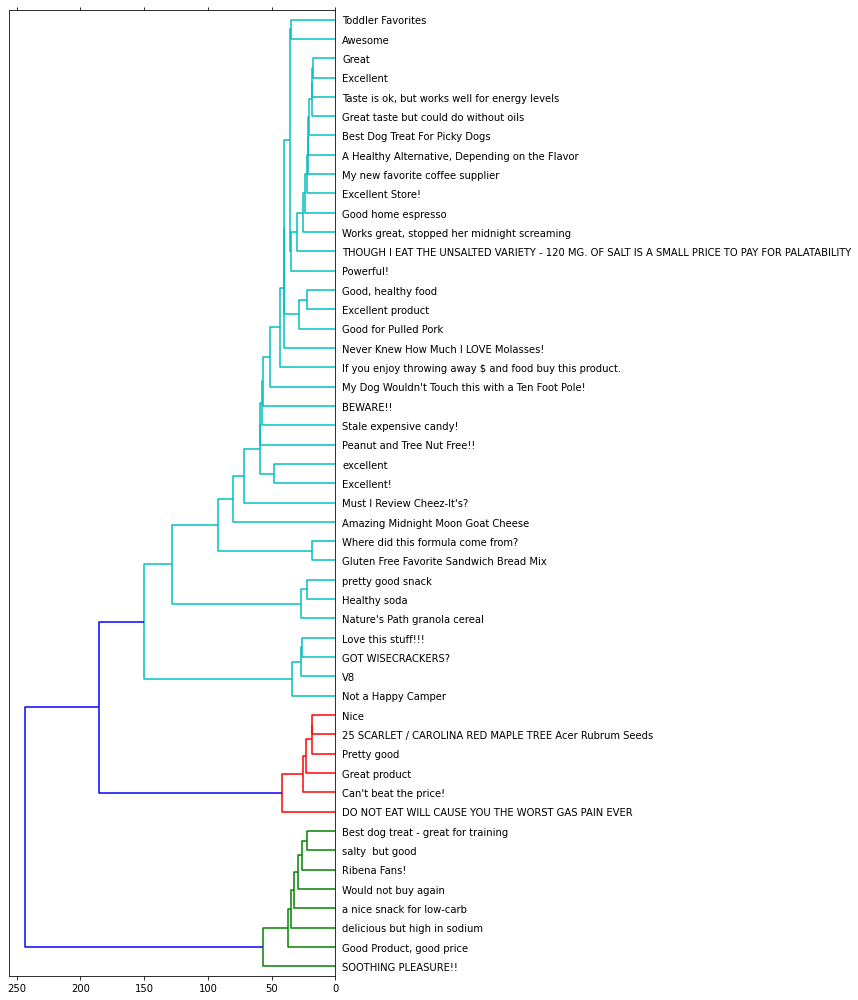

In [29]:
import matplotlib.pyplot as plt
plot_hierarchical_clusters(linkage_matrix,
                           p=50,  
                           food_data=df_text,
                           figure_size=(12, 14))